<a href="https://colab.research.google.com/github/KhunJahad/Flipr-Hackathon-6.0-ML/blob/master/Task_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm

import warnings
warnings.filterwarnings("ignore")

# Util Functions

In [151]:
def na_count(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  missing_data.head(20)

In [152]:
def statistics(train_dataset):
  train_stats = train_dataset.describe()
  train_stats = train_stats.transpose()
  return train_stats

In [153]:
def norm(x,train_stats):
  return (x - train_stats['mean']) / train_stats['std']

In [175]:
def preprocess(df):
  df.drop(columns=['Popuation [2001]'],inplace=True,axis=1)
  df.drop(columns=['City'],inplace=True,axis=1)
  df.drop(columns=['State','Type','SWM'],axis=1,inplace=True)
  
  for j in range(0,df.shape[0]):
    df['Population [2011]'][j]=str(df['Population [2011]'][j])
    df['Population [2011]'][j] = df['Population [2011]'][j].replace(',', '')
    df['Population [2011]'][j]=float(df['Population [2011]'][j])
  
  for col in df.columns:
    df[col] = df[col].fillna(df[col].median())

  return df

In [156]:
def num(x,y):
  diff=abs(x.flatten()-y.flatten())
  count=0;
  total=0;
  for item in diff:
    total+=1
    if item<1000:
      count+=1

  return 100*(count/total)

In [157]:
# Regression chart 
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Data Preprocessing

In [204]:
df_train=pd.read_csv(r"/content/Train_dataset - Train_data.csv")
df_train=preprocess(df_train)

y = df_train.pop('Covid Cases')

In [205]:
df_train

,Population [2011],Sex Ratio,Median Age,Avg Temp,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors
0,12442373.0,878.0,23.0,32.0,219.0,150.0,0.700440,10924403.0,159.0,4408916.0
1,11007835.0,858.0,27.0,30.0,215.0,196.0,0.920018,9444722.0,148.0,2379169.0
2,8436675.0,936.0,28.0,37.0,212.0,102.0,0.097085,7896728.0,123.0,636502.0
3,6809970.0,930.0,23.0,31.0,217.0,118.0,0.827744,6333272.0,110.0,126078.0
4,5570585.0,852.0,29.0,25.0,227.0,109.0,0.847941,4746138.0,73.0,284973.0
...,...,...,...,...,...,...,...,...,...,...
782,36954.0,846.0,23.0,28.0,68.0,103.0,0.035280,31263.0,19.0,284973.0
783,36947.0,945.0,23.0,36.0,62.0,136.0,0.056394,34915.0,22.0,1489500.0
784,36828.0,1019.0,28.0,28.0,98.0,138.0,0.066752,37528.0,27.0,106153.0
785,36805.0,900.0,24.0,6.0,63.0,145.0,0.627556,33125.0,15.0,24720.0


In [206]:
stats=statistics(df_train)
print(stats)

                   count          mean  ...           75%           max
Population [2011]  787.0  2.961837e+05  ...  2.247195e+05  1.244237e+07
Sex Ratio          787.0  9.057166e+02  ...  9.280000e+02  1.042000e+03
Median Age         787.0  2.617916e+01  ...  2.800000e+01  3.200000e+01
Avg Temp           787.0  3.094282e+01  ...  3.600000e+01  4.000000e+01
Toilets Avl        787.0  9.595172e+01  ...  1.170000e+02  2.270000e+02
Water Purity       787.0  1.502986e+02  ...  1.710000e+02  2.000000e+02
H Index            787.0  4.988364e-01  ...  7.011036e-01  9.997737e-01
Female Population  787.0  2.537475e+05  ...  1.898310e+05  1.092440e+07
# of hospitals     787.0  4.158577e+01  ...  6.600000e+01  1.590000e+02
Foreign Visitors   787.0  1.364006e+06  ...  1.489500e+06  4.684707e+06

[10 rows x 8 columns]


In [207]:
x = norm(df_train,stats)

In [208]:
x

,Population [2011],Sex Ratio,Median Age,Avg Temp,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors
0,14.094971,-0.753532,-1.521925,0.153381,4.097152,-0.011494,0.757803,14.021986,4.066954,1.917839
1,12.430270,-1.297271,0.392951,-0.136789,3.963963,1.759146,1.583174,12.077582,3.685940,0.639401
2,9.446583,0.823313,0.871670,0.878804,3.864072,-1.859118,-1.510136,10.043410,2.819998,-0.458219
3,7.558883,0.660191,-1.521925,0.008296,4.030558,-1.243243,1.236326,7.988919,2.369709,-0.779710
4,6.120647,-1.460393,1.350389,-0.862212,4.363529,-1.589673,1.312245,5.903315,1.088115,-0.679630
...,...,...,...,...,...,...,...,...,...,...
782,-0.300821,-1.623515,-1.521925,-0.426958,-0.930711,-1.820626,-1.742453,-0.292360,-0.782318,-0.679630
783,-0.300830,1.067996,-1.521925,0.733719,-1.130494,-0.550384,-1.663091,-0.287561,-0.678405,0.079042
784,-0.300968,3.079832,0.871670,-0.426958,0.068202,-0.473400,-1.624154,-0.284127,-0.505217,-0.792260
785,-0.300994,-0.155418,-1.043206,-3.618822,-1.097197,-0.203955,0.483841,-0.289913,-0.920869,-0.843550


In [209]:
x=x.values
y=y.values

In [210]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Model And Training

In [211]:
x_train.shape

(590, 10)

In [266]:
model=Sequential()
model.add(Dropout(0.2))
model.add(Dense(512, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(512, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

optim=tf.keras.optimizers.Adam(0.005)

model.compile(loss='mean_squared_error',optimizer=optim)
#monitor=EarlyStopping(monitor='val_loss',min_delta=1e-100,patience=100,verbose=1,mode='auto',restore_best_weights=True)
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=1000)#callbacks=[monitor])

Epoch 1/1000
19/19 - 0s - loss: 309475968.0000 - val_loss: 146095408.0000
Epoch 2/1000
19/19 - 0s - loss: 292010464.0000 - val_loss: 115685296.0000
Epoch 3/1000
19/19 - 0s - loss: 231095136.0000 - val_loss: 66870832.0000
Epoch 4/1000
19/19 - 0s - loss: 178173456.0000 - val_loss: 43987828.0000
Epoch 5/1000
19/19 - 0s - loss: 136268640.0000 - val_loss: 36374316.0000
Epoch 6/1000
19/19 - 0s - loss: 149856400.0000 - val_loss: 30731166.0000
Epoch 7/1000
19/19 - 0s - loss: 132729216.0000 - val_loss: 29611712.0000
Epoch 8/1000
19/19 - 0s - loss: 145992880.0000 - val_loss: 24672762.0000
Epoch 9/1000
19/19 - 0s - loss: 108813560.0000 - val_loss: 22013588.0000
Epoch 10/1000
19/19 - 0s - loss: 133134984.0000 - val_loss: 21593274.0000
Epoch 11/1000
19/19 - 0s - loss: 123823040.0000 - val_loss: 22100636.0000
Epoch 12/1000
19/19 - 0s - loss: 146236080.0000 - val_loss: 22183502.0000
Epoch 13/1000
19/19 - 0s - loss: 120522776.0000 - val_loss: 19094818.0000
Epoch 14/1000
19/19 - 0s - loss: 120191472.00

In [267]:
# Predict
pred_valid = model.predict(x_test)
pred_train=model.predict(x_train)

60.50847457627119
65.98984771573603


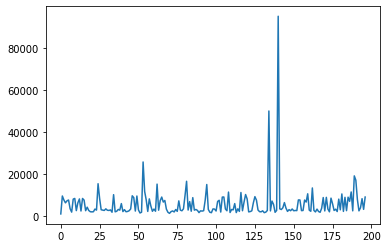

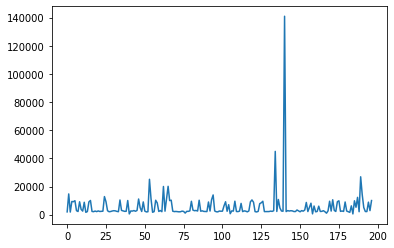

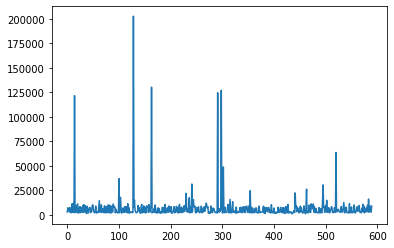

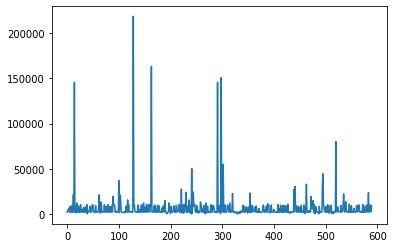

In [268]:
# chcking error range and plotting
print(num(pred_train,y_train)) 
print(num(pred_valid,y_test))

plt.plot(pred_valid)
plt.show()
plt.plot(y_test)
plt.show()

plt.plot(pred_train)
plt.show()
plt.plot(y_train)
plt.show()

In [269]:
# Measure RMSE error-- see how they perform .. i don't think this overfits 
score = np.sqrt(metrics.mean_squared_error(pred_valid,y_test))
print("Final score (RMSE): {}".format(score))

score_train=np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Final score (RMSE):Train {}".format(score_train))

Final score (RMSE): 4170.491937350717
Final score (RMSE):Train 3655.4869989235826


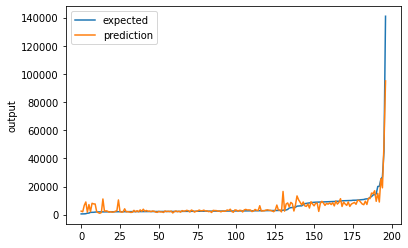

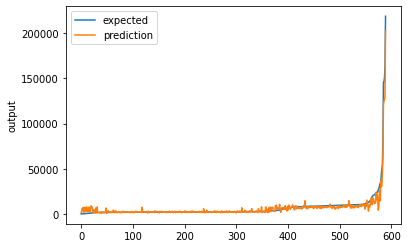

In [270]:
chart_regression(pred_valid.flatten(),y_test)
chart_regression(pred_train.flatten(),y_train)

[]

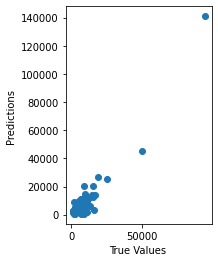

In [271]:
test_predictions = model.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_predictions,y_test)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.plot()

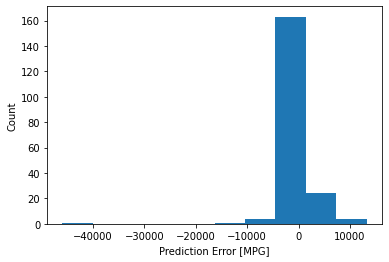

In [272]:
error = test_predictions - y_test.flatten()
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# Solution

The error prediciton curve is gaussian and i don't think its overfitting.

So I will go with this one

In [286]:
df_test=pd.read_csv(r'/content/Test_dataset - Test_data.csv')
city_name=df_test['City']
df_test=preprocess(df_test)

In [287]:
df_test.shape

(501, 10)

In [288]:
x_final = norm(df_test,stats)
print(x_final)

     Population [2011]  Sex Ratio  ...  # of hospitals  Foreign Visitors
0            -0.301030   0.687378  ...       -0.851593         -0.857376
1            -0.301054   0.768939  ...       -0.990144         -0.458219
2            -0.301079  -0.617597  ...       -0.851593         -0.706465
3            -0.301109  -0.508849  ...       -1.059419          1.917839
4            -0.301152  -0.780719  ...       -0.643768          1.095974
..                 ...        ...  ...             ...               ...
496          -0.341800  -1.569141  ...       -1.301883         -0.792431
497          -0.341944  -1.460393  ...       -1.232608         -0.792431
498          -0.342994  -1.433206  ...       -1.232608         -0.792431
499          -0.343577  -1.460393  ...       -1.163332         -0.792431
500          -0.314462  -1.161337  ...       -1.232608          1.095974

[501 rows x 10 columns]


In [289]:
x_final.isna().sum()

Population [2011]    0
Sex Ratio            0
Median Age           0
Avg Temp             0
Toilets Avl          0
Water Purity         0
H Index              0
Female Population    0
# of hospitals       0
Foreign Visitors     0
dtype: int64

In [290]:
print(x_final.shape)

(501, 10)


In [291]:
result=[]

output=model.predict(x_final)
city=city_name.values
for i in range(0,501):
  result.append([city[i],output[i]])

df=pd.DataFrame(result,columns=['City','Covid Cases'])
df.to_csv('solution 01.csv',index=False)